# Imports

## Librairies

In [5]:
import numpy as np
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

## Options

In [6]:
sns.set()
warnings.filterwarnings('ignore')

## Data

In [7]:
app_train = pd.read_csv('../data/application_train.csv')

# EDA

In [8]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
app_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int64  
 1    TARGET                        307511 non-null  int64  
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int64  
 7    AMT_INCOME_TOTAL              307511 non-null  float64
 8    AMT_CREDIT                    307511 non-null  float64
 9    AMT_ANNUITY                   307499 non-null  float64
 10   AMT_GOODS_PRICE               307233 non-null  float64
 11   NAME_TYPE_SUITE               306219 non-null  object 
 12   NAME_INCOME_TYPE            

## Distribution de la target

In [10]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

## Valeurs manquantes

In [11]:
def missing_values_table(df):
    # Total des valeurs manquantes
    miss_val = df.isnull().sum()

    # Pourcentage des valeurs manquantes
    miss_val_percent = 100 * df.isnull().sum() / len(df)

    # Dataframe pour les résultats
    miss_val_df = pd.concat([miss_val, miss_val_percent], axis=1)

    # Renommage des colonnes
    miss_val_df_ren_columns = miss_val_df.rename(
        columns= {0 : 'Valeurs manquantes', 1 : '% des valeurs total'}
    )

    # Tri du df par pourcentage de valeurs manquantes
    miss_val_df_ren_columns = miss_val_df_ren_columns[miss_val_df_ren_columns.iloc[:, 1] !=0].sort_values(
        '% des valeurs total', ascending=False).round(1)

    # Affichage des informations sommaires
    print(
        "Le jeu de données a " + str(df.shape[1]) + " colonnes.\n"
        "Il y a " + str(miss_val_df_ren_columns.shape[0]) + " colonnes qui ont des valeurs manquantes.")

    return miss_val_df_ren_columns

missing_values = missing_values_table(app_train)
missing_values.head(20)

Le jeu de données a 122 colonnes.
Il y a 67 colonnes qui ont des valeurs manquantes.


,Valeurs manquantes,% des valeurs total
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


Quand on va effectuer nos modèles de machine learning, il faudra trouver un moyen par rapport à ces valeurs nulles. On peut utiliser des modèles comme XGBoost qui peut gérer des valeurs manquantes sans imputation. 

Mais on peut également supprimer des colonnes qui ont un haut pourcentage de valeurs manquantes. Le souci actuel, c'est que pour l'instant on ne sait pas si ces colonnes seront utiles pour le modèle, donc pour l'instant on va laisser comme ça.

## Types de colonnes

In [12]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [13]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

## Encodage des variables catégoriques

In [14]:
le = LabelEncoder()
le_count = 0

# Itération à travers les colonnes
for col in app_train:
    if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique())) <= 2:
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col])
            le_count +=1

print(f"{le_count} colonnes ont été encodées.")

3 colonnes ont été encodées.


In [15]:
app_train = pd.get_dummies(app_train)
print(app_train.shape)

(307511, 243)


In [16]:
train_labels = app_train['TARGET']

## Anomalies

In [17]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [18]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Quelques soucis de valeurs négatives...

In [19]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]

print('Les non-anomalies font défaut sur %0.2f%% des prêts' % (100 * non_anom['TARGET'].mean()))
print('Les anomalies font défaut sur %0.2f%% des prêts' % (100 * anom['TARGET'].mean()))
print("Il y a %d jours d'emploi anormaux" % len(anom))

Les non-anomalies font défaut sur 8.66% des prêts
Les anomalies font défaut sur 5.40% des prêts
Il y a 55374 jours d'emploi anormaux


### Création d'une colonne anomalie

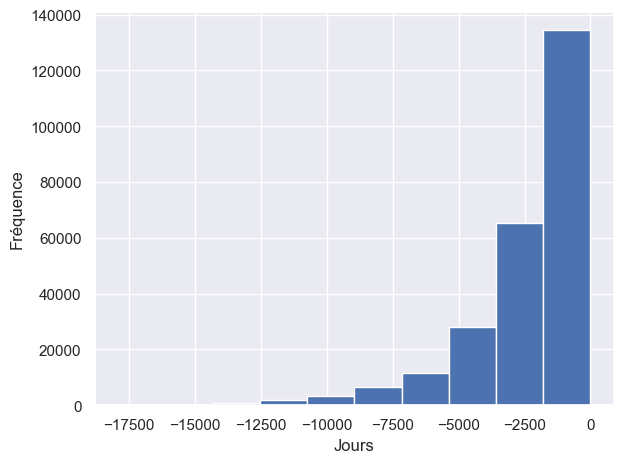

In [20]:
app_train['DAYS_EMPLOYED_ANOM'] = app_train['DAYS_EMPLOYED'] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)
app_train['DAYS_EMPLOYED'].plot.hist()

plt.xlabel('Jours')
plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

In [21]:
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982709

A mesure que le client vieillit, il existe uen relation linéaire négative avec la variable cible. Cela signifie qu'à mesure que les clients vieillissent, ils ont tendence à rembourser leurs prêts à temps plus souvent.

## Distribution par âges

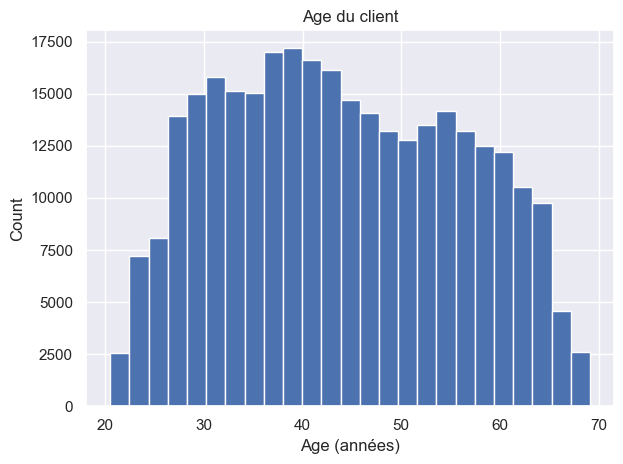

In [22]:
plt.hist(app_train['DAYS_BIRTH'] / 365, bins=25)
plt.title('Age du client')
plt.xlabel('Age (années)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

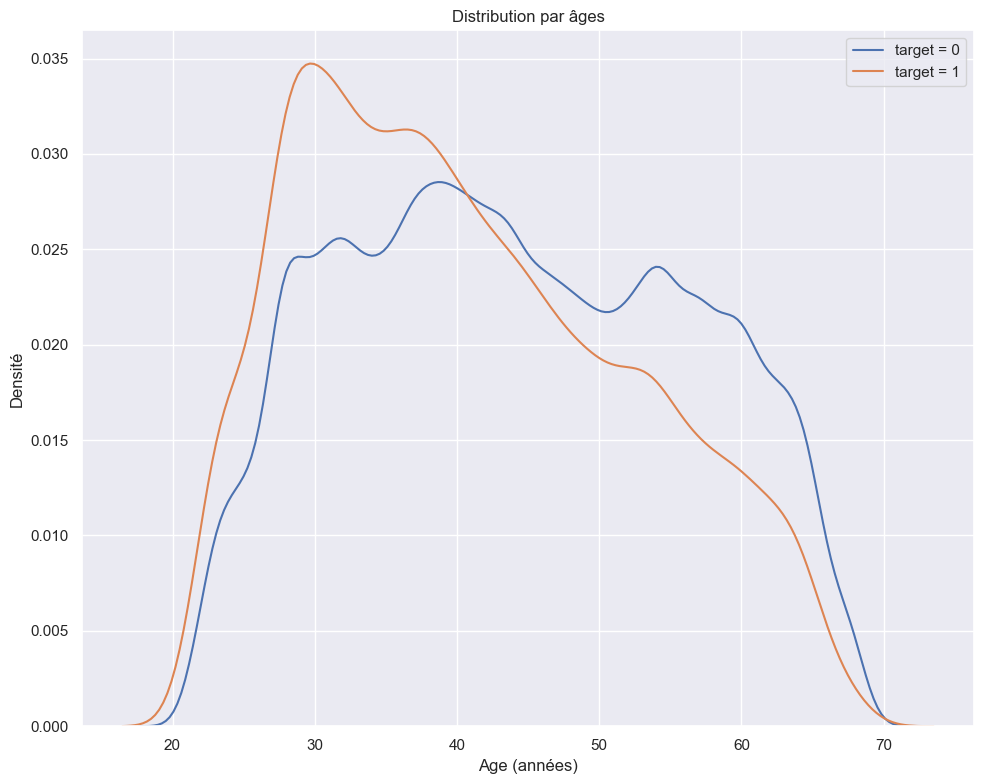

In [23]:
plt.figure(figsize=(10, 8))

sns.kdeplot(
    app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label='target = 0')

sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label='target = 1')

plt.title('Distribution par âges')
plt.legend()
plt.xlabel('Age (années)')
plt.ylabel('Densité')

plt.tight_layout()
plt.show()

La courbe de la variable cible (1) est bien plus inclinée vers la tranche d'âge la plus jeune. Même si la corrélation n'est pas réellement significative (-0,07), cette variable sera probablement utile dans un modèle de machine learning, car elle a un impact.

Regardons maintenant la moyenne des défauts de remboursement des prêts par tranche d'âge.

## Distribution par tranches d'âges

In [24]:
# Stockage de l'âge dans un jeu de données séparé
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], 
                                  bins=np.linspace(20, 70, num=11))

age_data.head()

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"


In [25]:
# On va grouper par tranches et calculer une moyenne
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


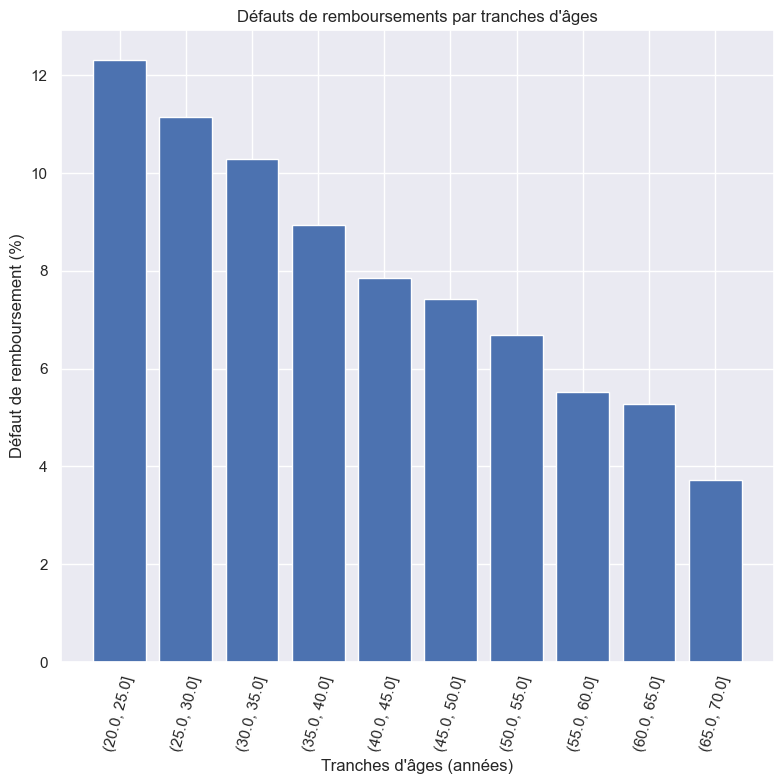

In [26]:
plt.figure(figsize=(8, 8))

# Graphique des tranches d'âge et la moyenne de la variable cible
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

plt.xticks(rotation=75)
plt.xlabel('Tranches d\'âges (années)')
plt.ylabel('Défaut de remboursement (%)')
plt.title('Défauts de remboursements par tranches d\'âges')

plt.tight_layout()
plt.show()

On remarque clairement qu'il y a une tendance de défauts de remboursements chez les jeunes, le taux est légèrement supérieur à 10%. Tandis qu'on est en dessous de 5% chez les personnes les plus âgées.

C'est une information qui peut être utilisée par la banque sur plusieurs facteurs. Cela n'autorise pas non plus la banque à refuser tous les prêts pour les jeunes, mais il y aura des mesures supplémentaires pour éviter ces défauts de remboursements.

## Sources externes

In [27]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
                     'DAYS_BIRTH']]

ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


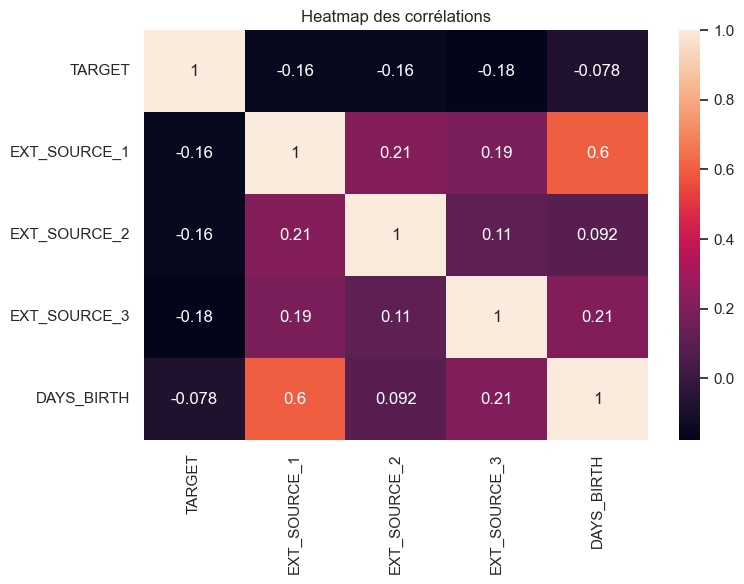

In [28]:
plt.figure(figsize=(8, 6))

sns.heatmap(ext_data_corrs, annot=True)
plt.title('Heatmap des corrélations')
plt.tight_layout()
plt.show()

Les trois sources externes ont des corrélations négatives avec la variable cible. On peut voir également une corrélation positive entre DAYS_BIRTH et EXT_SOURCE_1, cela indique qu'il y a un rapport avec l'âge du client pour cette source par rapport aux autres.

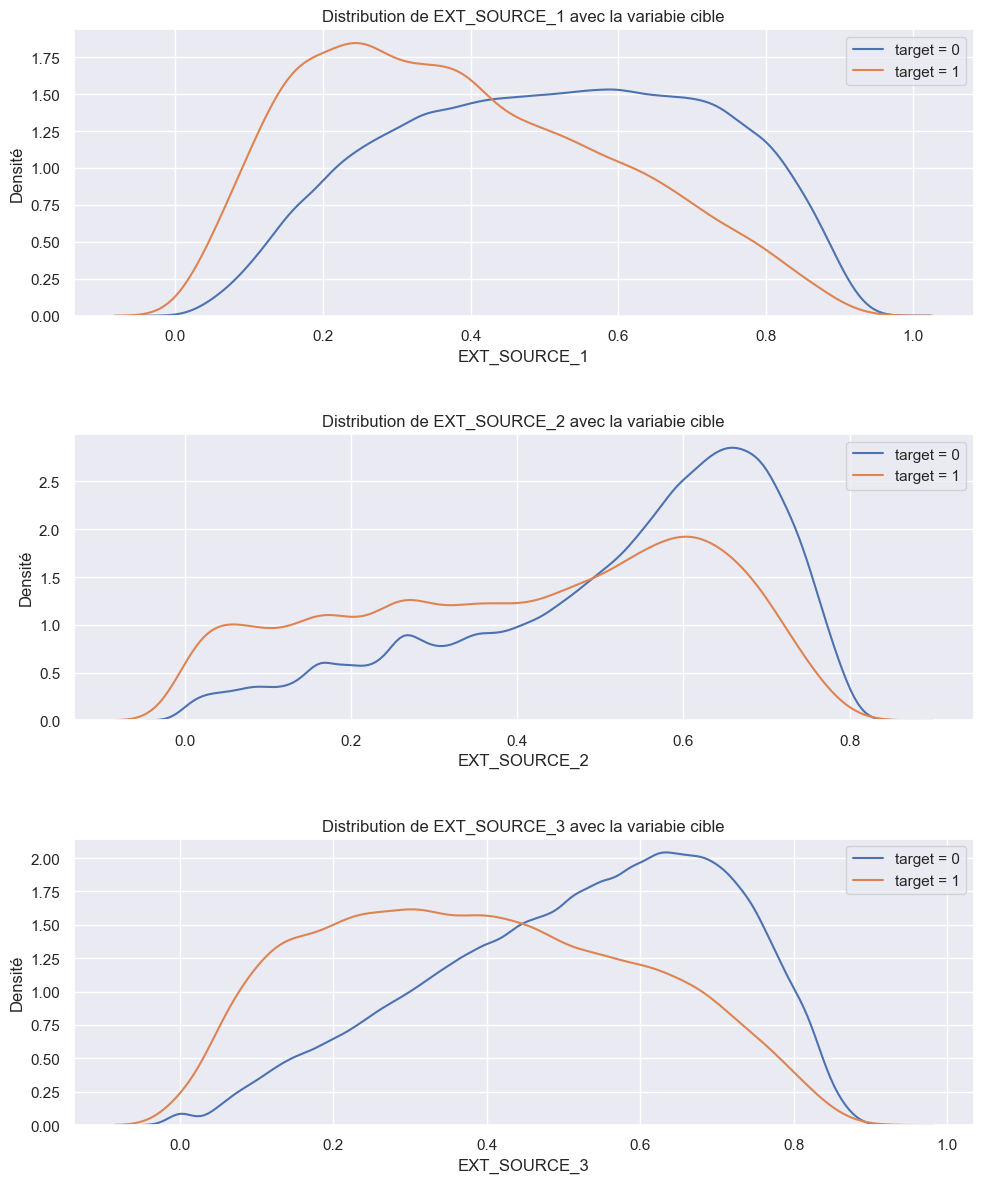

In [29]:
plt.figure(figsize=(10, 12))

for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    plt.subplot(3, 1, i + 1)
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label='target = 0')
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label='target = 1')

    plt.title('Distribution de %s avec la variabie cible' % source)
    plt.legend()
    plt.xlabel('%s' % source)
    plt.ylabel('Densité')

plt.tight_layout(h_pad=3)
plt.show()

EXT_SOURCE_3 montre la plus grosse différence entre les valeurs de la variabie cible. On peut clairement voir que cette feature est liée à la probabilité qu'un demandeur rembourse un prêt.

## Feature Engineering

### Polynomial  Features

In [30]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures

poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
                          'DAYS_BIRTH', 'TARGET']]

imputer = SimpleImputer(strategy='median')
poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns=['TARGET'])

poly_features = imputer.fit_transform(poly_features)
poly_transformer = PolynomialFeatures(degree=3)

In [31]:
poly_transformer.fit(poly_features)

poly_features = poly_transformer.transform(poly_features)
print(poly_features.shape)

(307511, 35)


In [32]:
poly_transformer.get_feature_names_out(input_features=[
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'
])[:15]

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2'], dtype=object)

In [33]:
poly_features = pd.DataFrame(poly_features, columns=poly_transformer.get_feature_names_out([
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'
]))

poly_features['TARGET'] = poly_target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

print(poly_corrs.head(10))
print(poly_corrs.tail())

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


In [34]:
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on='SK_ID_CURR', how='left')

print(app_train_poly.shape)

(307511, 280)


## Credit

In [35]:
app_train_domain = app_train.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

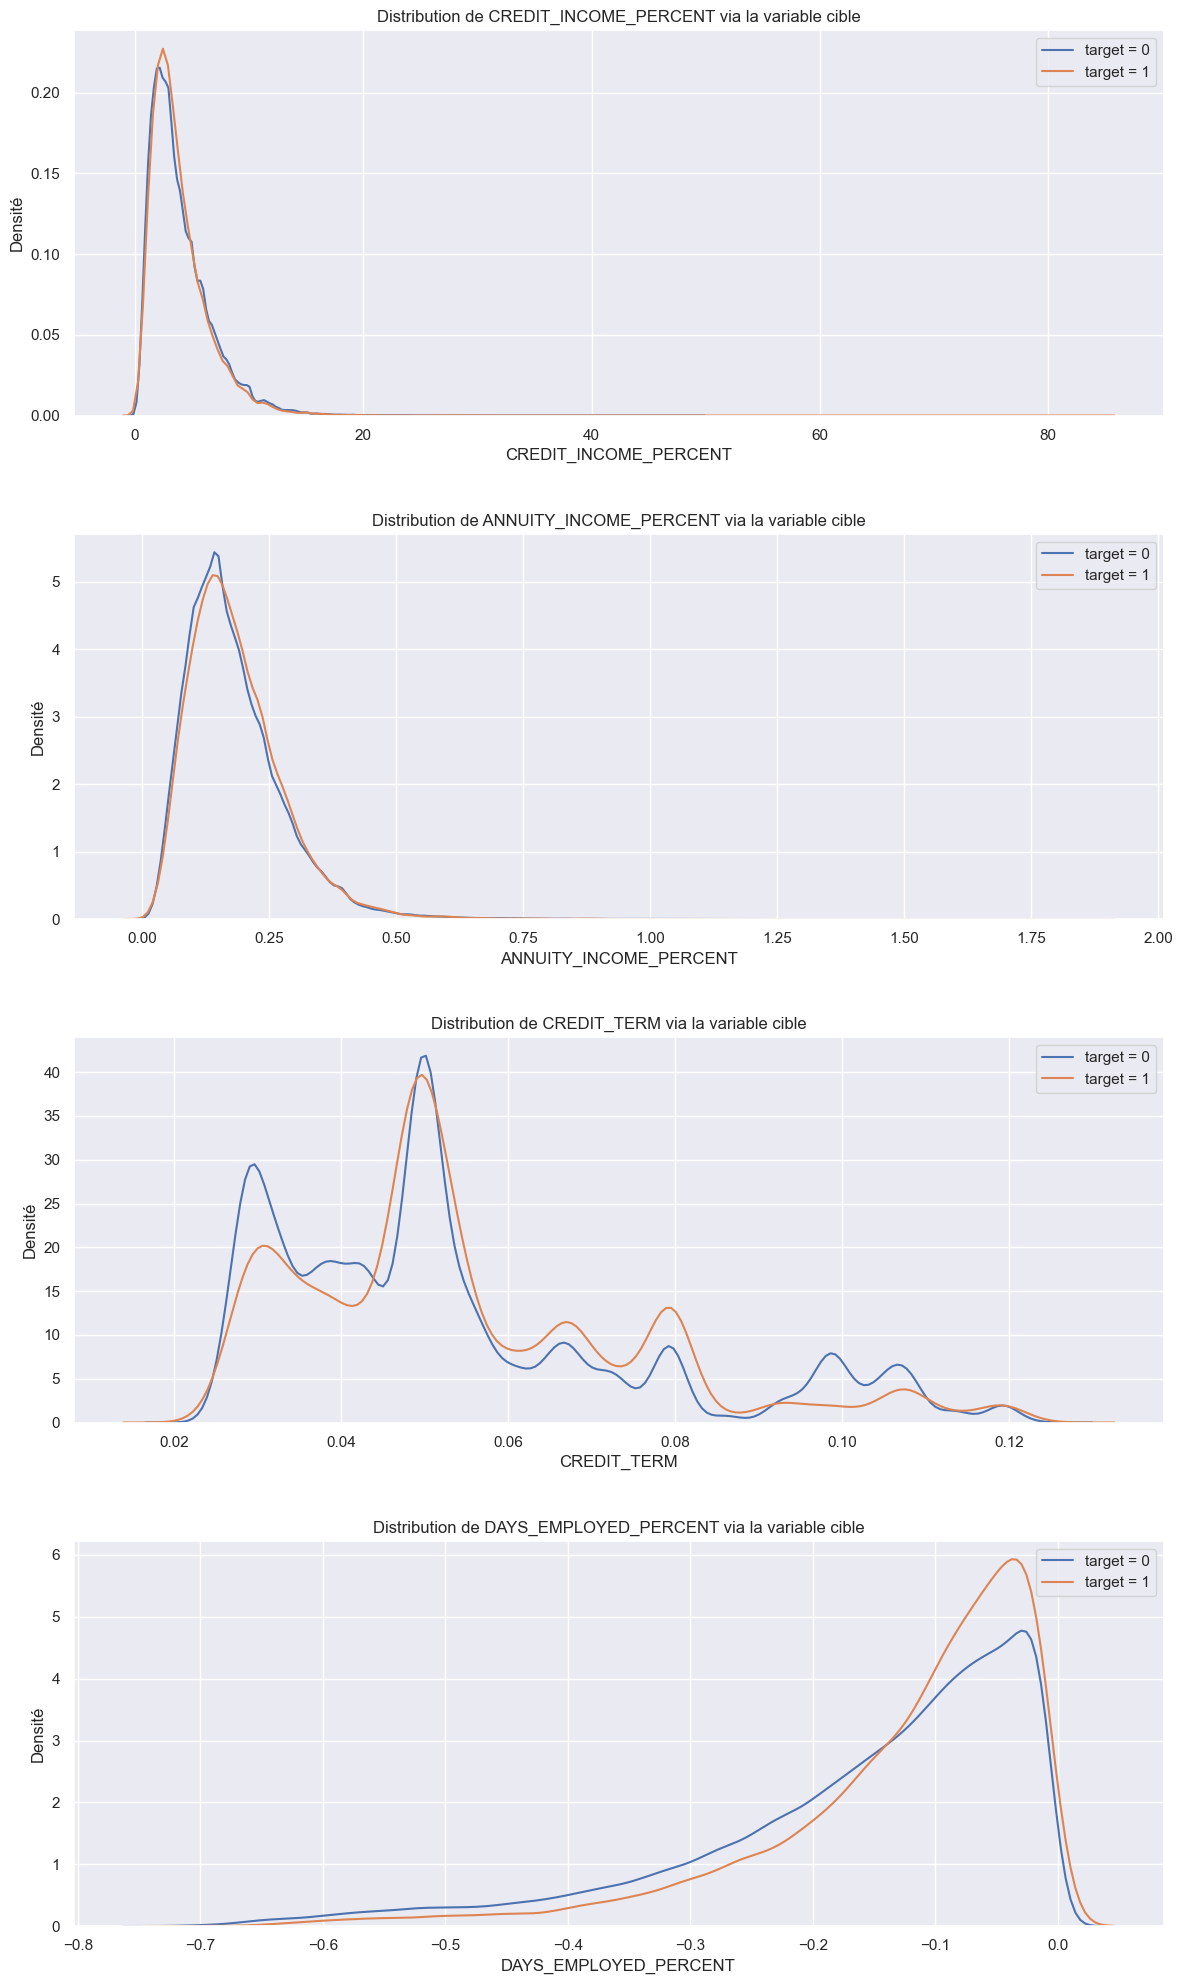

In [36]:
plt.figure(figsize = (12, 20))

for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    plt.subplot(4, 1, i + 1)
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target = 0')
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target = 1')
    
    plt.title('Distribution de %s via la variable cible' % feature)
    plt.legend()
    plt.xlabel('%s' % feature); plt.ylabel('Densité');
    
plt.tight_layout(h_pad=3)

In [33]:
app_train.to_csv('data/cleaned/df.csv', sep=";", encoding='utf-8-sig', index=False)